In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-qm9dmpyh
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-qm9dmpyh
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101055 sha256=7ff2be110c7c8b2997dd742800cdef1749b0771c7f7ed47213c85d5c4f8c4bac
  Stored in directory: /tmp/pip-ephem-wheel-cache-vhfwodf6/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [19]:
from IPython.display import clear_output
import scipy
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
#from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf

#from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.layers import UpSampling2D, Conv2D

from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.io import imread
import os
from IPython.display import Image
#from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tqdm import tqdm_notebook
clear_output()

In [20]:
from google.colab import files

# Upload the Kaggle API key (kaggle.json)
uploaded = files.upload()


KeyboardInterrupt: ignored

In [ ]:
#!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

In [ ]:
!unzip chest-xray-masks-and-labels.zip

In [10]:
base_path = Path('..') / 'content' / 'Lung Segmentation'
all_images_df = pd.DataFrame({'path': list(base_path.glob('**/*.*p*g'))})
all_images_df.sample(3)

,path
206,../content/Lung Segmentation/CXR_png/CHNCXR_02...
639,../content/Lung Segmentation/CXR_png/CHNCXR_02...
1569,../content/Lung Segmentation/test/CHNCXR_0560_...


In [21]:
all_images_df['modality'] = all_images_df['path'].map(lambda x: x.parent.stem)
all_images_df['source'] = all_images_df['path'].map(lambda x: x.stem.split('_')[0])
all_images_df['image_id'] = all_images_df['path'].map(lambda x: '_'.join(x.stem.split('_')[1:2]))
all_images_df = all_images_df[all_images_df['modality'].isin(['masks', 'CXR_png'])]
print(all_images_df['modality'].value_counts())
all_images_df.sample(3)

CXR_png    800
masks      704
Name: modality, dtype: int64


,path,modality,source,image_id
425,../content/Lung Segmentation/CXR_png/CHNCXR_03...,CXR_png,CHNCXR,0393
1387,../content/Lung Segmentation/masks/CHNCXR_0589...,masks,CHNCXR,0589
980,../content/Lung Segmentation/masks/CHNCXR_0060...,masks,CHNCXR,0060


In [22]:
flat_images_df = all_images_df.pivot_table(index=['source', 'image_id'],
                          columns='modality',
                          values='path',
                          aggfunc='first').\
    reset_index().\
    sort_values('image_id').\
    dropna()
print(flat_images_df.shape[0])
flat_images_df.sample(3)

704


modality,source,image_id,CXR_png,masks
705,MCUCXR,0058,../content/Lung Segmentation/CXR_png/MCUCXR_00...,../content/Lung Segmentation/masks/MCUCXR_0058...
767,MCUCXR,0251,../content/Lung Segmentation/CXR_png/MCUCXR_02...,../content/Lung Segmentation/masks/MCUCXR_0251...
29,CHNCXR,0030,../content/Lung Segmentation/CXR_png/CHNCXR_00...,../content/Lung Segmentation/masks/CHNCXR_0030...


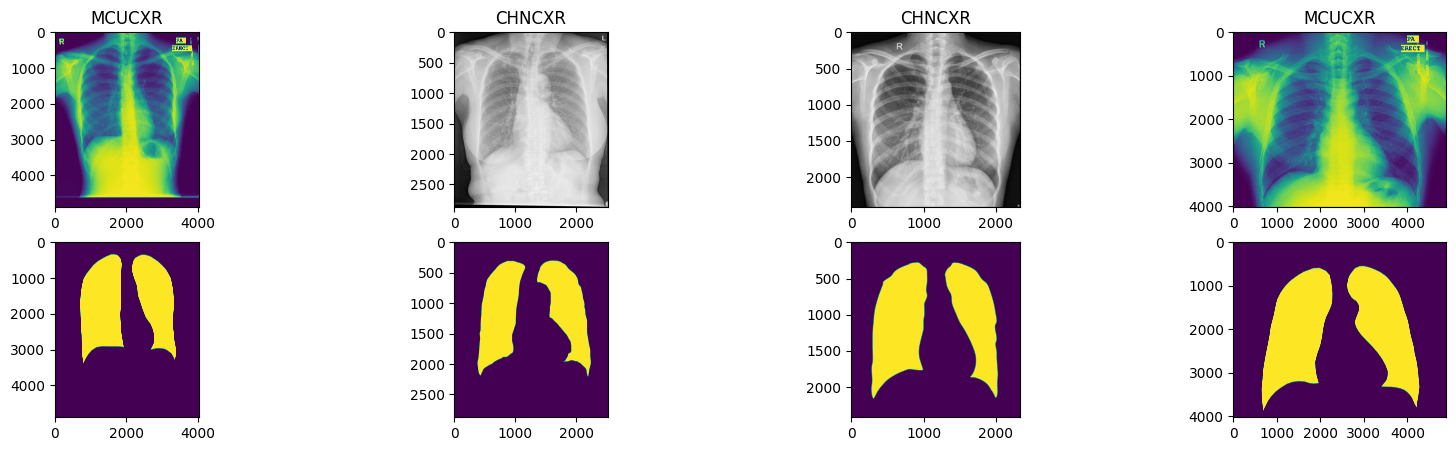

In [23]:
fig, (a_axs, b_axs) = plt.subplots(2, 4, figsize=(20, 5))
for a_ax, b_ax, (_, c_row) in  zip(a_axs, b_axs, flat_images_df.sample(20).iterrows()):
    a_img = imread(c_row['CXR_png'])
    a_ax.imshow(a_img)
    a_ax.set_title(c_row['source'])
    b_img = imread(c_row['masks'])
    b_ax.imshow(b_img)

In [24]:
#all_images_df = all_images_df.sample(4096)
images_a_df = all_images_df[all_images_df['modality']=='CXR_png'].copy()
images_a_df['image_path'] = images_a_df['path'].map(str)
images_b_df = all_images_df[all_images_df['modality']=='masks'].copy()
images_b_df['image_path'] = images_b_df['path'].map(str)

In [25]:
images_a_df

,path,modality,source,image_id,image_path
0,../content/Lung Segmentation/CXR_png/CHNCXR_05...,CXR_png,CHNCXR,0597,../content/Lung Segmentation/CXR_png/CHNCXR_05...
1,../content/Lung Segmentation/CXR_png/CHNCXR_05...,CXR_png,CHNCXR,0520,../content/Lung Segmentation/CXR_png/CHNCXR_05...
2,../content/Lung Segmentation/CXR_png/CHNCXR_01...,CXR_png,CHNCXR,0149,../content/Lung Segmentation/CXR_png/CHNCXR_01...
3,../content/Lung Segmentation/CXR_png/MCUCXR_02...,CXR_png,MCUCXR,0251,../content/Lung Segmentation/CXR_png/MCUCXR_02...
4,../content/Lung Segmentation/CXR_png/CHNCXR_04...,CXR_png,CHNCXR,0401,../content/Lung Segmentation/CXR_png/CHNCXR_04...
...,...,...,...,...,...
795,../content/Lung Segmentation/CXR_png/CHNCXR_00...,CXR_png,CHNCXR,0080,../content/Lung Segmentation/CXR_png/CHNCXR_00...
796,../content/Lung Segmentation/CXR_png/CHNCXR_05...,CXR_png,CHNCXR,0571,../content/Lung Segmentation/CXR_png/CHNCXR_05...
797,../content/Lung Segmentation/CXR_png/CHNCXR_03...,CXR_png,CHNCXR,0396,../content/Lung Segmentation/CXR_png/CHNCXR_03...
798,../content/Lung Segmentation/CXR_png/CHNCXR_05...,CXR_png,CHNCXR,0546,../content/Lung Segmentation/CXR_png/CHNCXR_05...


## The Model

In [26]:
IMAGE_SIZE = 128, 128
IMAGE_A_CHANNELS = 1 # X-ray
IMAGE_B_CHANNELS = 1 # Segmentation

In [27]:
class CycleGAN():
    def __init__(self,
                 img_rows,
                 img_cols,
                 channels_A,
                 channels_B,
                 parallel_channels=True,
                 ):
        """
        args:
          parallel_channels: process each input and output channel on its own
        """
        # Input shape
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels_A = channels_A
        self.channels_B = channels_B
        self.parallel_channels = parallel_channels
        self.img_shape_A = (self.img_rows, self.img_cols, self.channels_A)
        self.img_shape_B = (self.img_rows, self.img_cols, self.channels_B)
        # Calculate output shape of D (PatchGAN)
        patch_r = int(self.img_rows / 2**4)
        patch_c = int(self.img_cols / 2**4)
        self.disc_patch = (patch_r, patch_c, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        #optimizer = Adam(0.0002, 0.5)
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002)


        # Build and compile the discriminators
        self.d_A = self.build_discriminator(self.img_shape_A, suffix='A')
        self.d_B = self.build_discriminator(self.img_shape_B, suffix='B')
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        # -------------------------
        # Construct Computational
        #   Graph of Generators
        # -------------------------

        # Build the generators
        self.g_AB = self.build_generator(
            self.img_shape_A, self.img_shape_B, suffix='AB')
        self.g_BA = self.build_generator(
            self.img_shape_B, self.img_shape_A, suffix='BA')

        # Input images from both domains
        img_A = Input(shape=self.img_shape_A, name='ImageA')
        img_B = Input(shape=self.img_shape_B, name='ImageB')

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_B)
        img_B_id = self.g_AB(img_A)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)

    def build_generator(self, in_img_shape, out_img_shape, suffix=''):
        """U-Net Generator"""
        in_chan = in_img_shape[-1]
        out_chan = out_img_shape[-1]
        gf_down = self.gf // in_chan if self.parallel_channels else self.gf
        gf_up = self.gf // in_chan if self.parallel_channels else self.gf

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size,
                       strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1,
                       padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=in_img_shape)
        # Downsampling

        def _ds_pipe(in_d0):
            d1 = conv2d(in_d0, gf_down)
            d2 = conv2d(d1, gf_down*2)
            d3 = conv2d(d2, gf_down*4)
            d4 = conv2d(d3, gf_down*8)
            return d1, d2, d3, d4

        if (in_chan > 1) and self.parallel_channels:
            chan_list = []
            for i in range(in_chan):
                c_d0 = layers.Lambda(
                    lambda x: x[:, :, :, i:(i+1)],
                    name='InSel{}_{}'.format(suffix, i))(d0)
                chan_list.append(_ds_pipe(c_d0))
            d1, d2, d3, d4 = [
                layers.concatenate(list(c_outs))
                for c_outs in zip(*chan_list)]
        else:
            d1, d2, d3, d4 = _ds_pipe(d0)

        # Upsampling
        def _us_pipe(chan_count, d1, d2, d3, d4):
            u1 = deconv2d(d4, d3, gf_up*4)
            u2 = deconv2d(u1, d2, gf_up*2)
            u3 = deconv2d(u2, d1, gf_up)

            u4 = UpSampling2D(size=2)(u3)
            output_img = Conv2D(chan_count, kernel_size=4, strides=1,
                            padding='same', activation='sigmoid')(u4)
            return output_img


        if (out_chan > 1) and self.parallel_channels:
            chan_list = []
            for i in range(out_chan):
                chan_list.append(_us_pipe(1, d1, d2, d3, d4))
            output_img = layers.concatenate(chan_list)
        else:
            output_img = _us_pipe(out_chan, d1, d2, d3, d4)


        return Model(d0, output_img, name='Gen{}_{}_{}_{}-{}'.format(suffix, *in_img_shape, out_img_shape[-1]))

    def build_discriminator(self, img_shape, suffix=''):
        in_chan = img_shape[-1]
        df = self.df // in_chan if self.parallel_channels else self.df

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size,
                       strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=img_shape)

        def _disc_block(in_img):
            d1 = d_layer(in_img, df, normalization=False)
            d2 = d_layer(d1, df*2)
            d3 = d_layer(d2, df*4)
            d4 = d_layer(d3, df*8)
            return d4

        if (in_chan > 1) or not self.parallel_channels:
            chan_list = []
            for i in range(in_chan):
                c_img = layers.Lambda(
                    lambda x: x[:, :, :, i:(i+1)],
                    name='DiscSelect{}_{}'.format(suffix, i))(img)
                chan_list.append(_disc_block(c_img))
            d4 = layers.concatenate(chan_list)
        else:
            d4 = _disc_block(img)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity, name='Disc{}_{}_{}_{}'.format(suffix, *img_shape))

In [28]:
cg = CycleGAN(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_A_CHANNELS, IMAGE_B_CHANNELS)

## Model graph

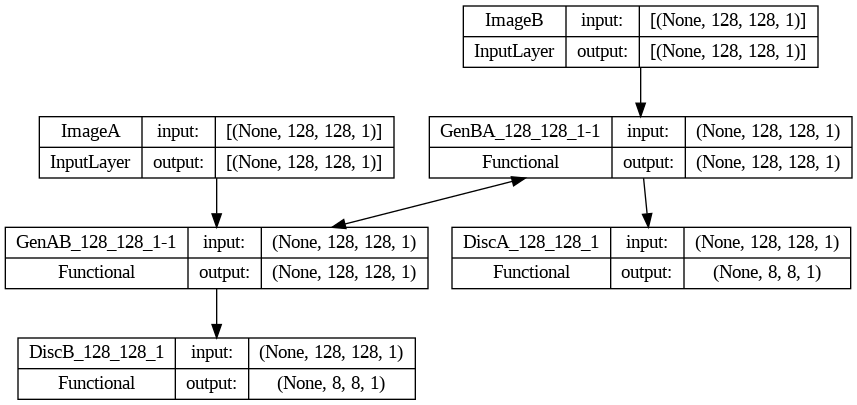

In [29]:
from tensorflow.keras.utils import plot_model

# Assuming 'cg.combined' is your Keras model
plot_model(cg.combined, show_shapes=True, to_file='model_plot.png')


## Generators

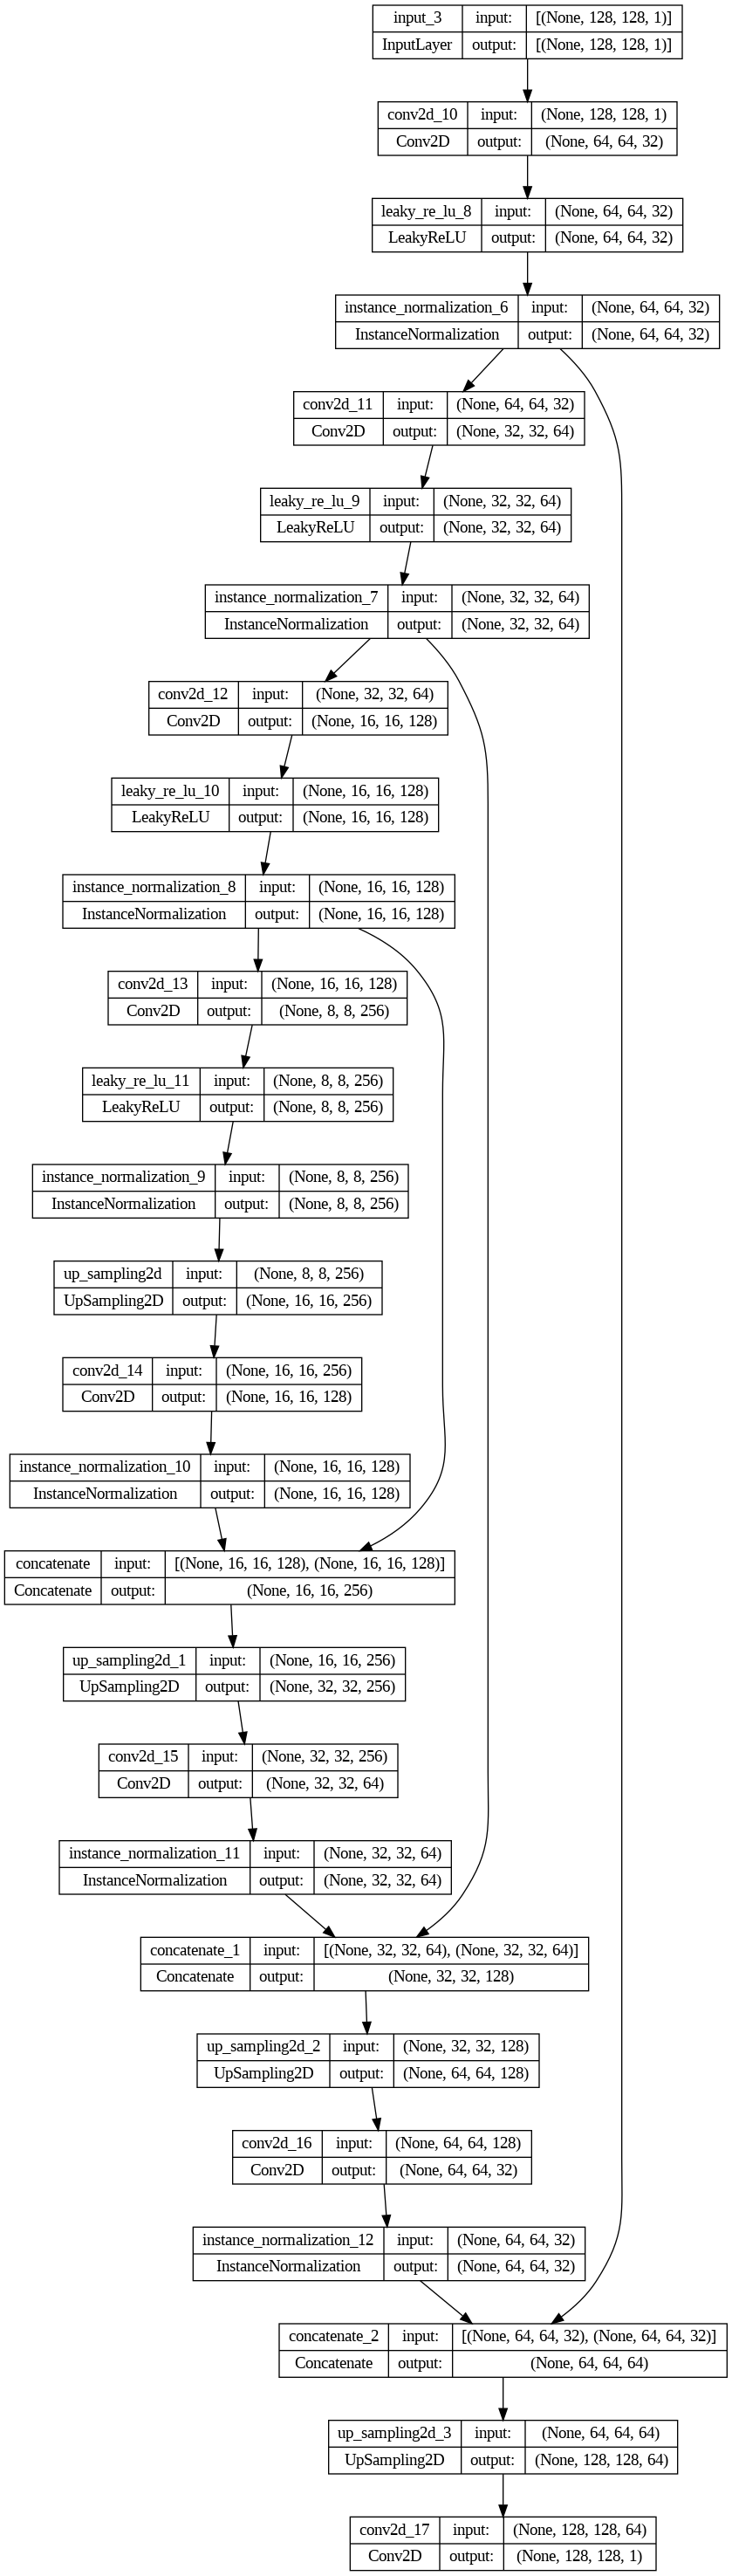

In [30]:
plot_model(cg.g_AB, show_shapes=True, to_file='model_plot.png')

## Discriminator

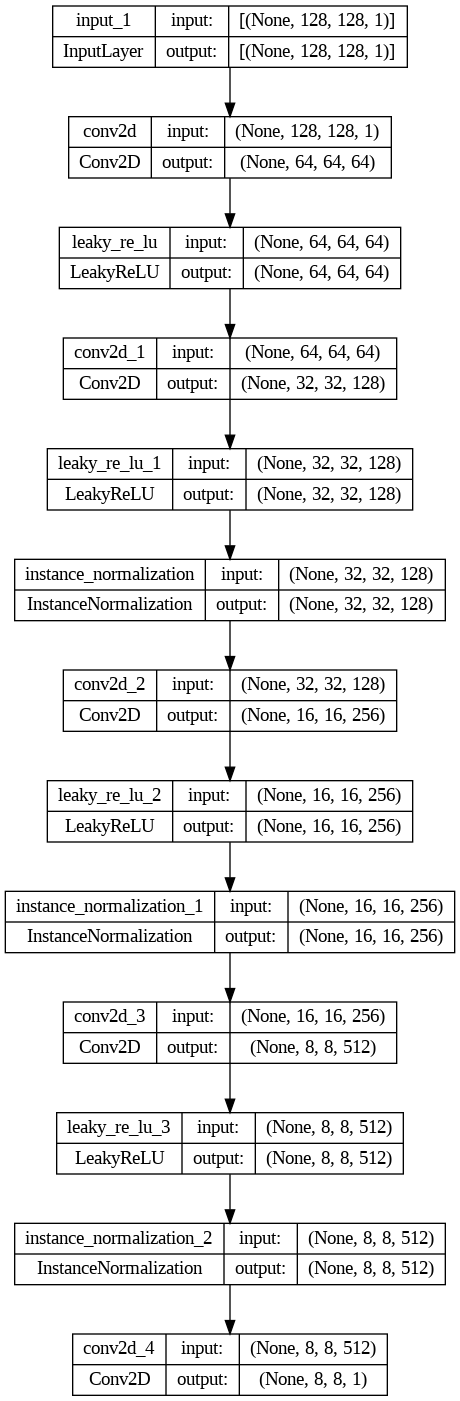

In [31]:
plot_model(cg.d_A, show_shapes=True, to_file='model_plot.png')

## Data Augmentation

In [32]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False,
                  rotation_range = 10,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],
                  brightness_range = [0.7, 1.3],
                  horizontal_flip = True,
                  vertical_flip = False,
                  fill_mode = 'reflect',
                   data_format = 'channels_last',
              preprocessing_function=lambda x: x/255.0)

core_idg = ImageDataGenerator(**dg_args)

## Data loaders

In [33]:
from sklearn.model_selection import train_test_split

class loader_class():
    def __init__(self, a_df, b_df, goal_size):
        self.goal_size = goal_size
        self.a_df = a_df
        self.b_df = b_df
        self._a_gen = None
        self._b_gen = None
        self.n_batches = 0

    def _make_gen(self, batch_size, use_cached):
        if use_cached and (self._a_gen is not None):
            return self._a_gen, self._b_gen


        a_gen = core_idg.flow_from_dataframe(self.a_df,
                                               x_col='image_path',
                                               y_col='image_path',
                                               class_mode=None,
                                               target_size=self.goal_size,
                                               color_mode='grayscale',
                                               batch_size=batch_size)
        b_gen = core_idg.flow_from_dataframe(self.b_df,
                                                 x_col='image_path',
                                                 y_col='image_path',
                                                 class_mode=None,
                                                 target_size=self.goal_size,
                                                 color_mode='grayscale',
                                                 batch_size=batch_size)
        if use_cached:
            self._a_gen = a_gen
            self._b_gen = b_gen

        return a_gen, b_gen

    def load_batch(self, batch_size):
        a_gen, b_gen = self._make_gen(batch_size, use_cached=False)
        for a_x, b_x in zip(a_gen, b_gen):
            if (a_x.shape[0]==batch_size) and (b_x.shape[0]==batch_size):
                yield a_x, b_x
            else:
                yield None, None

    def load_data(self, domain="A", batch_size=1, is_testing=False):
        a_gen, b_gen = self._make_gen(batch_size, use_cached=True)
        if domain == "A":
            return next(a_gen)
        elif domain == "B":
            return next(b_gen)
        else:
            raise ValueError("Unknown domain")


loader_obj = loader_class(
    a_df=images_a_df,
    b_df=images_b_df,
    goal_size=IMAGE_SIZE
)
loader_obj.load_data(domain="A", batch_size=1, is_testing=True).shape

Found 800 validated image filenames.
Found 704 validated image filenames.


(1, 128, 128, 1)

1/1 [==============================] - 0s 17ms/step


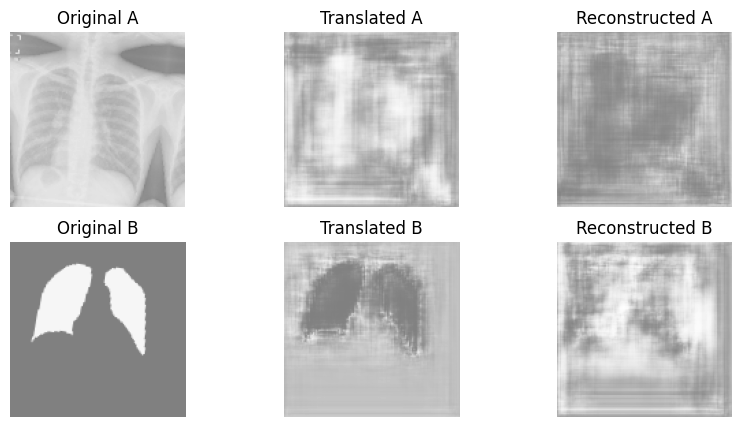

In [34]:
def sample_images(cyc_gan, data_loader, epoch, batch_i):
    plt.close('all')
    r, c = 2, 3

    imgs_A = data_loader.load_data(domain="A", batch_size=1, is_testing=True)
    imgs_B = data_loader.load_data(domain="B", batch_size=1, is_testing=True)

    # Translate images to the other domain
    fake_B = cyc_gan.g_AB.predict(imgs_A)
    fake_A = cyc_gan.g_BA.predict(imgs_B)
    # Translate back to original domain
    reconstr_A = cyc_gan.g_BA.predict(fake_B)
    reconstr_B = cyc_gan.g_AB.predict(fake_A)

    gen_imgs = [imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B]

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c, figsize=(10, 5))
    cnt = 0
    for i in range(r):
        for j in range(c):
            c_img = np.clip(0.5 * gen_imgs[cnt][0]+0.5, 0, 1)
            axs[i,j].imshow(c_img.squeeze(), cmap='gray', vmin=0, vmax=1)
            axs[i, j].set_title('{} {}'.format(titles[j], 'A' if i==0 else 'B'))
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("{:03d}_{:03d}.png".format(epoch, batch_i))
sample_images(cg, loader_obj, 0, 0)

## Train Model

In [35]:
BATCH_SIZE = 64
EPOCHS = 30

1/1 [==============================] - 0s 28ms/step


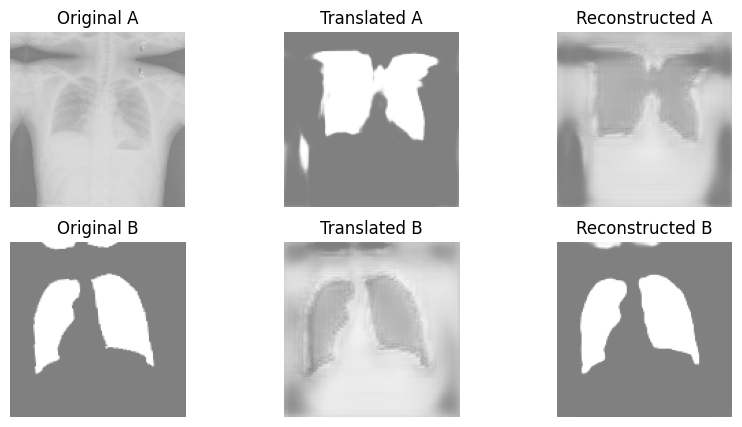

In [36]:
start_time = datetime.datetime.now()

# Adversarial loss ground truths
valid = np.ones((BATCH_SIZE,) + cg.disc_patch)
fake = np.zeros((BATCH_SIZE,) + cg.disc_patch)

for epoch in tqdm_notebook(range(EPOCHS), desc='Epochs'):
    for batch_i, (imgs_A, imgs_B) in tqdm_notebook(enumerate(loader_obj.load_batch(BATCH_SIZE)), desc='Batch'):
        #  Train Discriminators
        if imgs_A is None:
            break
        # Translate images to opposite domain
        fake_B = cg.g_AB.predict(imgs_A)
        fake_A = cg.g_BA.predict(imgs_B)

        # Train the discriminators (original images = real / translated = Fake)
        dA_loss_real = cg.d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = cg.d_A.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = cg.d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = cg.d_B.train_on_batch(fake_B, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        # Total disciminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)

        #  Train Generators
        # Train the generators
        g_loss = cg.combined.train_on_batch([imgs_A, imgs_B],
                                                [valid, valid,
                                                imgs_A, imgs_B,
                                                imgs_A, imgs_B])

        elapsed_time = datetime.datetime.now() - start_time

    # Plot the progress at each epoch
    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                            % ( epoch, EPOCHS,
                                                                batch_i, loader_obj.n_batches,
                                                                d_loss[0], 100*d_loss[1],
                                                                g_loss[0],
                                                                np.mean(g_loss[1:3]),
                                                                np.mean(g_loss[3:5]),
                                                                np.mean(g_loss[5:6]),
                                                                elapsed_time))

    clear_output()
    sample_images(cg, loader_obj, epoch, batch_i)

1/1 [==============================] - 0s 86ms/step


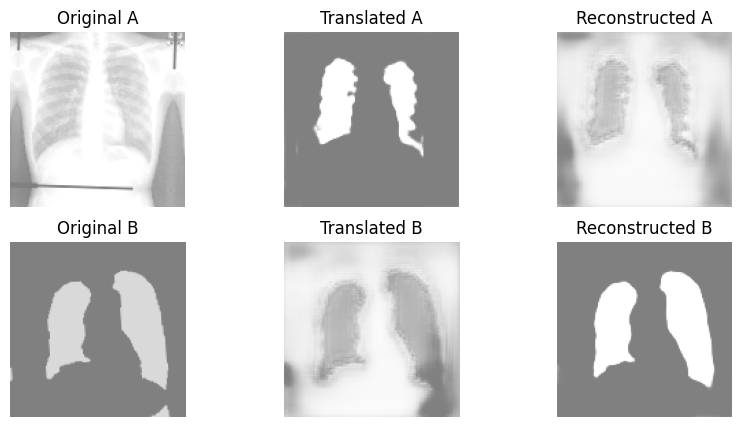

In [37]:
sample_images(cg, loader_obj, EPOCHS, 2)